In [18]:
# Kaggle Competition - Houses Prices
# Competition step:
# 1. download data
# 2. configure data: 
#    a. numerical data: standardization, fillna()
#    b. categorical data(unordered): encode, fillna() 
#    c. categorical data(unordered): encode, fillna()
# 3. K-fold
# 4. model selection, feature engineering
# 5. submit prediction

In [19]:
# pre: download script

import os
import hashlib
import zipfile
import tarfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

# automatically data download script
# ----------------------------------
# check if data existed
def download(name, cache_dir=os.path.join('..', 'data')):
    assert name in DATA_HUB, f'{name} is not exsited in {DATA_HUB}'
    # retreive url and sha-1 key
    url, sha1_hash = DATA_HUB[name]
    # check if data file cached
    file = os.path.join(cache_dir, url.split('/')[-1])
    os.makedirs(cache_dir, exist_ok=True)
    if os.path.exists(file):
        sha1 = hashlib.sha1()
        with open(file, 'rb') as f:
            while True:
                data = f.read(1048576)   # read data
                if not data:
                    break
                sha1.update(data)        # hash cache data for checking
        if sha1.hexdigest() == sha1_hash:
            return file                 # check success: return cache data file
    # check unsuccess: download and save data file
    print(f'downloading target data {name} from {url}')
    r = requests.get(url, stream=True, verify=True)
    with open(file, 'wb') as f:
        f.write(r.content)
    return file

def download_extract(name, folder=None):
    file = download(name)
    # get directory of fname
    extract_dir = os.path.dirname(file)
    data_dir, extension = os.path.splitext(file)
    if extension == '.zip':
        # open file with zipfile object
        fp = zipfile.ZipFile(file, 'r')
    elif extension == '.tar' or '.gz':
        # open file with tarfile object
        fp = tarfile.open(file, 'r')
    else:
        assert False, 'Only support zip/tar file'
    # extract file to target directory
    fp.extractall(extract_dir)
    return os.path.join(extract_dir, folder) if folder else data_dir

def download_d2l_dataset():
    for name in DATA_HUB:
        download(name)

In [20]:
# 1. download and extract data(manully downloaded)
file_dir = './data/house-prices-advanced-regression-techniques.zip'
extract_dir = './data/HousePricing'
fp = zipfile.ZipFile(file_dir)
fp.extractall(extract_dir)

import pandas as pd

house_train = pd.read_csv(extract_dir + '/train.csv', index_col='Id')
house_test = pd.read_csv(extract_dir + '/test.csv', index_col='Id')
# house_train_test = pd.concat()
print(house_train.Exterior2nd.dtype)
print(house_train.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
print(house_test.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

object
    MSSubClass MSZoning  LotFrontage  LotArea SaleType SaleCondition  \
Id                                                                     
1           60       RL         65.0     8450       WD        Normal   
2           20       RL         80.0     9600       WD        Normal   
3           60       RL         68.0    11250       WD        Normal   
4           70       RL         60.0     9550       WD       Abnorml   

    SalePrice  
Id             
1      208500  
2      181500  
3      223500  
4      140000  
      MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
Id                                                                            
1461          20       RH         80.0    11622    2010       WD        Normal
1462          20       RL         81.0    14267    2010       WD        Normal
1463          60       RL         74.0    13830    2010       WD        Normal
1464          60       RL         78.0     9978    2010       WD     

In [21]:
# encoding features for model
# 1. label encoding: good for non-linear model, like boosting, forest
# 2. one-hot encoding: good for linear model, like regression, NN
import torch

def label_encode(df_data):
    X = df_data
    for name in X.select_dtypes(['category']):
        X[name] = X[name].cat.codes   # ordered/unordered codes instead of string
    return X

def onehot_encode(df_data):
    X = df_data
    X = pd.get_dummies(X)   # we have clean up null data, so no need for 'dummpy_na = True'
    return X

# if we want to train a linear model, we use one-hot
train_X = onehot_encode(train_X)
test_X = onehot_encode(test_X)
print(train_X.iloc[0:4, [0, 1, 2, -2, -1]])
print(test_X.iloc[0:4, [0, 1, 2, -2, -1]])
print(train_X.shape)
trainX = torch.tensor(onehot_encode(train_X).values, dtype=torch.float32)
testX = torch.tensor(onehot_encode(test_X).values, dtype=torch.float32)
trainy = torch.tensor(train_y, dtype=torch.float32)

    MSSubClass  LotFrontage   LotArea  SaleCondition_Partial  \
Id                                                             
1     0.067320    -0.184443 -0.217841                      0   
2    -0.873466     0.458096 -0.072032                      0   
3     0.067320    -0.055935  0.137173                      0   
4     0.302516    -0.398622 -0.078371                      0   

    SaleCondition_None  
Id                      
1                    0  
2                    0  
3                    0  
4                    0  
      MSSubClass  LotFrontage   LotArea  SaleCondition_Partial  \
Id                                                               
1461   -0.873466     0.458096  0.184340                      0   
1462   -0.873466     0.500932  0.519702                      0   
1463    0.067320     0.201080  0.464294                      0   
1464    0.067320     0.372424 -0.024105                      0   

      SaleCondition_None  
Id                        
1461          

In [22]:
# root mean-squared error, RMSE
# root mean-squared logarithmic error, RMSLE
import torch
import numpy as np
from torch import nn
from d2l import torch as d2l

def RMSLE(net, X, y):
    predictions = net(X)
    clamped_preds = torch.clamp(predictions, 1, float('inf'))
    rmsle = torch.sqrt(loss(torch.log(clamped_preds), torch.log(y)))
    return rmsle

# baseline
# --------
# net with only one layer
net = nn.Sequential(nn.Linear(trainX.shape[1], 1))

# loss
loss = nn.MSELoss()

# optimizer
lr = 5
weight_decay = 0.1
optimizer = torch.optim.Adam(net.parameters(), lr, weight_decay=weight_decay)

# fit
def fit(net, train_X, train_y, test_X, test_y, n_epochs, loss, optimizer, batch_size):
    train_score, test_score = [], []
    train_iter = d2l.load_array((train_X, train_y), batch_size)
    for epoch in range(n_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
        train_score.append(RMSLE(net, train_X, train_y))
        if test_y is not None:
            test_score.append(RMSLE(net, test_X, test_y))
    return train_score, test_score

# k-fold
def k_fold(k, i, X, y):
    assert k > 1
    fold_length = X.shape[0] // k
    X_train, y_train = None, None
    for k_idx in range(k):
        idx = slice(k_idx * fold_length, (k_idx + 1) * fold_length)  # index(start, end)
        X_part, y_part = X[idx, :], y[idx]
        if k_idx == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train ,y_train, X_valid, y_valid

# final fit
def fit_score(net, k, X, y, n_epochs, loss, optimizer, batch_size):
    train_score_sum, valid_score_sum = 0, 0
    for k_idx in range(k):
        data = k_fold(k, k_idx, X, y)
        train_score, valid_score = fit(net, *data, n_epochs, loss, optimizer, batch_size)
        train_score_sum += train_score[-1]
        valid_score_sum += valid_score[-1]
        print(f'{k_idx + 1} fold, training RMSLE {float(train_score[-1]):f}',  
              f'validation RMSLE {float(valid_score[-1]):f}' )
    return train_score_sum / k, valid_score_sum / k

k = 10
epochs = 100
batch_size = 64
train_score, valid_score = fit_score(net, k, trainX, trainy, epochs, loss, optimizer, batch_size)
print(train_score)
print(valid_score)

1 fold, training RMSLE 0.173972 validation RMSLE 0.172931
2 fold, training RMSLE 0.150624 validation RMSLE 0.140747
3 fold, training RMSLE 0.143139 validation RMSLE 0.129527
4 fold, training RMSLE 0.135311 validation RMSLE 0.167001
5 fold, training RMSLE 0.135082 validation RMSLE 0.160829
6 fold, training RMSLE 0.139173 validation RMSLE 0.119550
7 fold, training RMSLE 0.137235 validation RMSLE 0.138822
8 fold, training RMSLE 0.138597 validation RMSLE 0.127590
9 fold, training RMSLE 0.130604 validation RMSLE 0.180807
10 fold, training RMSLE 0.135889 validation RMSLE 0.142633
tensor(0.1420, grad_fn=<DivBackward0>)
tensor(0.1480, grad_fn=<DivBackward0>)


In [23]:
# train and submit with whole dataset

def fit_predict(net, X_train ,y_train, X_test, n_epochs, loss, optimizer, batch_size):
    train_score, _ = fit(net, X_train, y_train, None, None, n_epochs, loss, optimizer, batch_size)  # Dont need to get test score
    print(f'training RMSLE {float(train_score[-1]):f}')
    prediction = net(X_test).detach().numpy()
    return prediction.reshape((-1, 1))

sale_price = fit_predict(net, trainX, trainy, testX, epochs, loss, optimizer, batch_size)

training RMSLE 0.136478


In [24]:
submission_data = pd.read_csv(extract_dir + '/test.csv')
submission_data['SalePrice'] = pd.Series(sale_price.reshape(1, -1)[0])
print(submission_data.iloc[:4, :])
submission = pd.concat([submission_data['Id'], submission_data['SalePrice']], axis=1)
submission.to_csv('data/HousePricing/submission.csv', index=False)

     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1         Lvl    AllPub  ...        0    NaN    NaN        Gar2   12500   
2         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
3         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition     SalePrice  
0      6   2010        WD         Normal  104016.84375  
1      6   2010        WD         Normal  159896.65625  
2      3   2010        WD         Normal  194208.78125  
3      6   2010

In [25]:
# mutual information
from sklearn.feature_selection import mutual_info_regression

def MI_score(X, y):
    X = X.copy()
    for col in X.select_dtypes(['object', 'category']):
        X[col], _ = X[col].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name='MI_score', index=X.columns).sort_values(ascending=False)
    return mi_scores

mi_score = MI_score(df_train, house_train.iloc[:, -1].values)
print(mi_score)

# select high mutal information scores' features
X = df_train.copy()
X = X.loc[:, mi_score > 0.0]
X = torch.tensor(onehot_encode(X).values, dtype=torch.float32)
y = trainy

# fit new net with new optimizer
new_net = nn.Sequential(nn.Linear(X.shape[1], 1))
new_optimizer = torch.optim.Adam(new_net.parameters(), lr, weight_decay=weight_decay)

mi_train_score, mi_valid_score = fit_score(new_net, k, X, y, epochs, loss, new_optimizer, batch_size)
print(train_score)

print(valid_score)

Neighborhood    0.528789
GrLivArea       0.483198
YearBuilt       0.368893
TotalBsmtSF     0.367480
GarageArea      0.361999
                  ...   
PoolArea        0.000000
PoolQC          0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI_score, Length: 79, dtype: float64
1 fold, training RMSLE 0.173858 validation RMSLE 0.171125
2 fold, training RMSLE 0.151395 validation RMSLE 0.140488
3 fold, training RMSLE 0.143410 validation RMSLE 0.129547
4 fold, training RMSLE 0.135648 validation RMSLE 0.167668
5 fold, training RMSLE 0.135271 validation RMSLE 0.161657
6 fold, training RMSLE 0.139488 validation RMSLE 0.119657
7 fold, training RMSLE 0.137657 validation RMSLE 0.138495
8 fold, training RMSLE 0.139062 validation RMSLE 0.126565
9 fold, training RMSLE 0.131228 validation RMSLE 0.180017
10 fold, training RMSLE 0.136157 validation RMSLE 0.144144
tensor(0.1420, grad_fn=<DivBackward0>)
tensor(0.1480, grad_fn=<DivBackward0>)


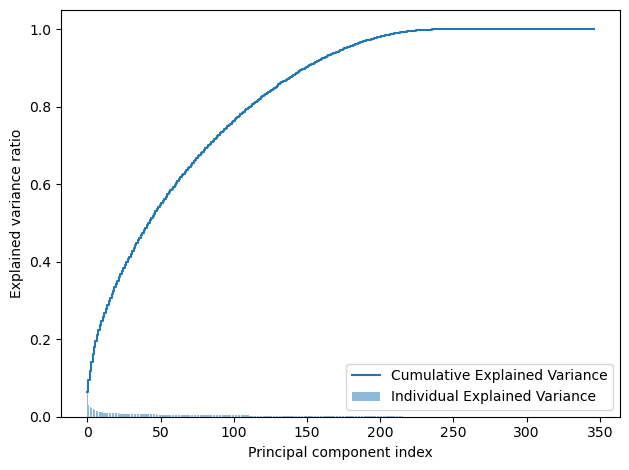

(1460, 347)


In [29]:
# PCA 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

def apply_PCA(X, is_standardized=True):
    if is_standardized == False:
        ss = StandardScaler()
        X_std = ss.fit_transform(X)
    pca = PCA()
    X_pca = pca.fit_transform(X_std)

    # create PCA dataframe
    pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=pca_columns)

    # create loadings dataframe
    loadings = pd.DataFrame(pca.components_.T, columns=pca_columns, index=X.columns)

    # plot explained variance
    evr = pca.explained_variance_ratio_
    plt.bar(range(X.shape[1]), evr, alpha=0.5, align='center', 
            label='Individual Explained Variance')
    
    # plot cumulative explained variance
    cum_evr = np.cumsum(evr)
    plt.step(range(X.shape[1]), cum_evr, where='mid', 
             label='Cumulative Explained Variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    return X_pca, loadings, pca

train_X_pca, train_X_loadings, pca = apply_PCA(pd.DataFrame(X.numpy()), is_standardized=False)
print(train_X_pca.shape)